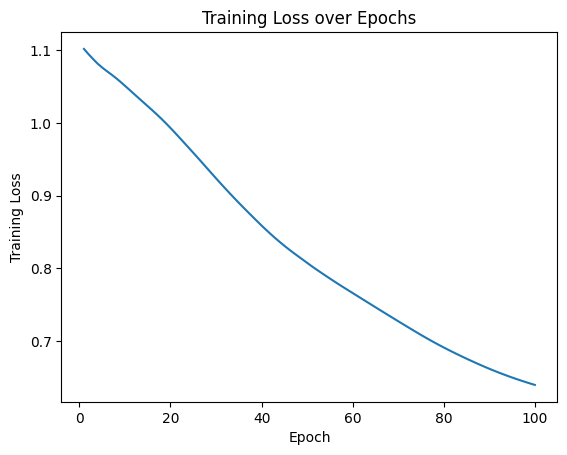

RuntimeError: mat1 and mat2 shapes cannot be multiplied (120x4 and 64x64)

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 轉換資料為 PyTorch 張量
X = torch.tensor(iris.data, dtype=torch.float32)
y = torch.tensor(iris.target, dtype=torch.long)

# 劃分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化資料
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定義原始任務模型
class OriginalModel(nn.Module):
    def __init__(self):
        super(OriginalModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

# 創建原始任務模型
original_model = OriginalModel()

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(original_model.parameters(), lr=0.001)

# 訓練原始任務模型
epochs = 100
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = original_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# 繪製訓練損失
plt.plot(range(1, epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

# 將原始模型的中間層作為新模型的特徵提取器
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.original_model = original_model
        self.fc = nn.Linear(64, 32)

    def forward(self, x):
        x = self.original_model.fc1(x)
        x = torch.relu(x)
        x = self.original_model.fc2(x)
        x = torch.relu(x)
        x = self.fc(x)
        return x

# 創建特徵提取器
feature_extractor = FeatureExtractor(original_model)

# 將 NumPy 陣列轉換為 PyTorch 張量
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# 從 NumPy 陣列轉換為 PyTorch 張量的 X_test_scaled
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# 凍結特徵提取器的權重
for param in feature_extractor.parameters():
    param.requires_grad = False

# 定義新模型（目標任務模型）
class NewModel(nn.Module):
    def __init__(self, feature_extractor):
        super(NewModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.fc = nn.Linear(32, 3)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.relu(x)
        x = torch.softmax(self.fc(x), dim=1)
        return x

# 創建新模型
new_model = NewModel(feature_extractor)

# 將 NumPy 陣列轉換為 PyTorch 張量的 y_train
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_train_tensor = y_train.clone().detach()

# 定義新模型的損失函數和優化器
criterion_new = nn.CrossEntropyLoss()
optimizer_new = optim.Adam(new_model.parameters(), lr=0.001)

# 訓練新模型
epochs = 100
losses_new = []

for epoch in range(epochs):
    optimizer_new.zero_grad()
    outputs_new = new_model(X_train_scaled_tensor)
    loss_new = criterion_new(outputs_new, y_train_tensor)
    loss_new.backward()
    optimizer_new.step()
    losses_new.append(loss_new.item())

# 繪製訓練損失
plt.plot(range(1, epochs + 1), losses_new)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('New Model Training Loss over Epochs')
plt.show()

# 評估新模型
with torch.no_grad():
    outputs_test = new_model(X_test_scaled_tensor)
    _, predicted = torch.max(outputs_test, 1)
    correct = (predicted == y_test).sum().item()
    total = y_test.size(0)
    accuracy = correct / total
    print('Test Accuracy:', accuracy)
